In [1]:
import pandas as pd
import os

# Folder containing the CSV files
folder_path = 'result'

# List to hold dataframes
dfs = []

# Iterate over all files in the folder
for filename in os.listdir(folder_path):
    if filename.endswith('.csv'):
        print(f'Processing {filename}')
        file_path = os.path.join(folder_path, filename)
        df = pd.read_csv(file_path)
        dfs.append(df)

merged_df = pd.concat(dfs, ignore_index=True)



merged_df.info()

Processing evaluation_results_25.csv
Processing evaluation_results_50.csv
Processing evaluation_results_120.csv
Processing evaluation_results_90.csv
Processing evaluation_results_70.csv
Processing evaluation_results_45.csv
Processing evaluation_results_15.csv
Processing evaluation_results_0.csv
Processing evaluation_results_40.csv
Processing evaluation_results_30.csv
Processing evaluation_results_60.csv
Processing evaluation_results_10.csv
Processing evaluation_results_100.csv
Processing evaluation_results_85.csv
Processing evaluation_results_115.csv
Processing evaluation_results_110.csv
Processing evaluation_results_35.csv
Processing evaluation_results_20.csv
Processing evaluation_results_5.csv
Processing evaluation_results_105.csv
Processing evaluation_results_80.csv
Processing evaluation_results_55.csv
Processing evaluation_results_75.csv
Processing evaluation_results_65.csv
Processing evaluation_results_95.csv
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125 entries, 0 to 124


In [2]:
merged_df = merged_df.dropna()

merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 124 entries, 0 to 124
Data columns (total 12 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   question                      124 non-null    object 
 1   self_contained                124 non-null    bool   
 2   retrieved_relavant_info_rank  124 non-null    float64
 3   retrieved_info                124 non-null    object 
 4   baseline_response             124 non-null    object 
 5   finetune_response             124 non-null    object 
 6   baseline_eval                 124 non-null    object 
 7   finetune_eval                 124 non-null    object 
 8   baseline_with_rag_response    124 non-null    object 
 9   finetune_with_rag_response    124 non-null    object 
 10  baseline_with_rag_eval        124 non-null    object 
 11  finetune_with_rag_eval        124 non-null    object 
dtypes: bool(1), float64(1), object(10)
memory usage: 11.7+ KB


In [3]:
import ast
import eval 

def convert_to_eval_result(eval_str):
    eval_dict = ast.literal_eval(eval_str)
    return eval.EvalResult(eval_dict)

average_results = {}
for col in merged_df.columns:
    if col.endswith('_eval'):
        print(col)
        merged_df[col] = merged_df[col].apply(convert_to_eval_result)
        average_results[col] = eval.average_eval_results(merged_df[col]).to_dict()
        print(average_results[col])
        print("\n")



baseline_eval
{'overall_score': 5.941129032258065, 'overall_rationale': None, 'grammar_score': 7.346774193548387, 'grammar_rationale': None, 'logic_score': 5.637096774193548, 'logic_rationale': None, 'relevance_score': 5.881451612903225, 'relevance_rationale': None}


finetune_eval
{'overall_score': 6.123387096774193, 'overall_rationale': None, 'grammar_score': 7.375, 'grammar_rationale': None, 'logic_score': 5.862903225806452, 'logic_rationale': None, 'relevance_score': 6.189516129032258, 'relevance_rationale': None}


baseline_with_rag_eval
{'overall_score': 6.289516129032258, 'overall_rationale': None, 'grammar_score': 7.568548387096774, 'grammar_rationale': None, 'logic_score': 5.887096774193548, 'logic_rationale': None, 'relevance_score': 5.854838709677419, 'relevance_rationale': None}


finetune_with_rag_eval
{'overall_score': 6.080645161290323, 'overall_rationale': None, 'grammar_score': 7.358870967741935, 'grammar_rationale': None, 'logic_score': 5.75, 'logic_rationale': None, 

In [4]:
# Extract overall_score from the specified columns and copy the question column
new_df = merged_df[['question','self_contained', 'retrieved_relavant_info_rank', 'baseline_eval', 'finetune_eval', 'baseline_with_rag_eval', 'finetune_with_rag_eval']].copy()
new_df[['baseline_eval', 'finetune_eval', 'baseline_with_rag_eval', 'finetune_with_rag_eval']] = new_df[['baseline_eval', 'finetune_eval', 'baseline_with_rag_eval', 'finetune_with_rag_eval']].applymap(lambda x: x.overall_score)

# Rename the columns for clarity
new_df.columns = ['question','self_contained', 'retrieved_relavant_info_rank', 'baseline_overall_score', 'finetune_overall_score', 'baseline_with_rag_overall_score', 'finetune_with_rag_overall_score']

# Update 'retrieved_relavant_info_rank' to True if the value is between 0 and 5
new_df['retrieved_relavant_info_rank'] = new_df['retrieved_relavant_info_rank'].apply(lambda x: True if 0 <=x and x < 5 else False)
# Rename 'retrieved_relavant_info_rank' to 'retrieved_relavant_info'
new_df = new_df.rename(columns={'retrieved_relavant_info_rank': 'retrieved_info'})

print(new_df.head())

                                            question  self_contained  \
0  What factors should be considered when choosin...            True   
1  What is the version range mentioned for the co...           False   
3  How can version updates affect contributors in...            True   
4  What is the purpose of the method that applies...           False   
5  What is the purpose of the _vector_divlike_op ...           False   

   retrieved_info  baseline_overall_score  finetune_overall_score  \
0           False                     9.0                     1.0   
1           False                     2.0                     7.5   
3           False                     8.0                     8.0   
4           False                     8.0                     5.0   
5           False                     1.0                     1.0   

   baseline_with_rag_overall_score  finetune_with_rag_overall_score  
0                              5.0                              8.5  
1           

/tmp/ipykernel_22127/3947020179.py:3: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  new_df[['baseline_eval', 'finetune_eval', 'baseline_with_rag_eval', 'finetune_with_rag_eval']] = new_df[['baseline_eval', 'finetune_eval', 'baseline_with_rag_eval', 'finetune_with_rag_eval']].applymap(lambda x: x.overall_score)


In [13]:
from IPython.display import display

# Group by 'self_contained' and 'retrieved_info' and calculate the mean scores
# Group by 'self_contained' and 'retrieved_info' and calculate the mean scores
display(new_df.drop('question', axis=1).groupby(['self_contained']).mean())

display(new_df.drop('question', axis=1).groupby(['retrieved_info']).mean())

display(new_df.drop('question', axis=1).groupby(['self_contained', 'retrieved_info']).mean())



,retrieved_info,baseline_overall_score,finetune_overall_score,baseline_with_rag_overall_score,finetune_with_rag_overall_score
self_contained,,,,,
False,0.409836,5.221311,5.767213,6.265574,5.901639
True,0.460317,6.638095,6.468254,6.312698,6.253968


,self_contained,baseline_overall_score,finetune_overall_score,baseline_with_rag_overall_score,finetune_with_rag_overall_score
retrieved_info,,,,,
False,0.485714,5.757143,6.321429,6.021429,5.714286
True,0.537037,6.179630,5.866667,6.637037,6.555556


baseline_overall_score  finetune_overall_score  \
self_contained retrieved_info                                                   
False          False                         4.930556                6.027778   
               True                          5.640000                5.392000   
True           False                         6.632353                6.632353   
               True                          6.644828                6.275862   

                               baseline_with_rag_overall_score  \
self_contained retrieved_info                                    
False          False                                  5.916667   
               True                                   6.768000   
True           False                                  6.132353   
               True                                   6.524138   

                               finetune_with_rag_overall_score  
self_contained retrieved_info                                   
False          False                                  5.416667  
               True                                   6.600000  
True           False                                  6.029412  
               True                                   6.517241

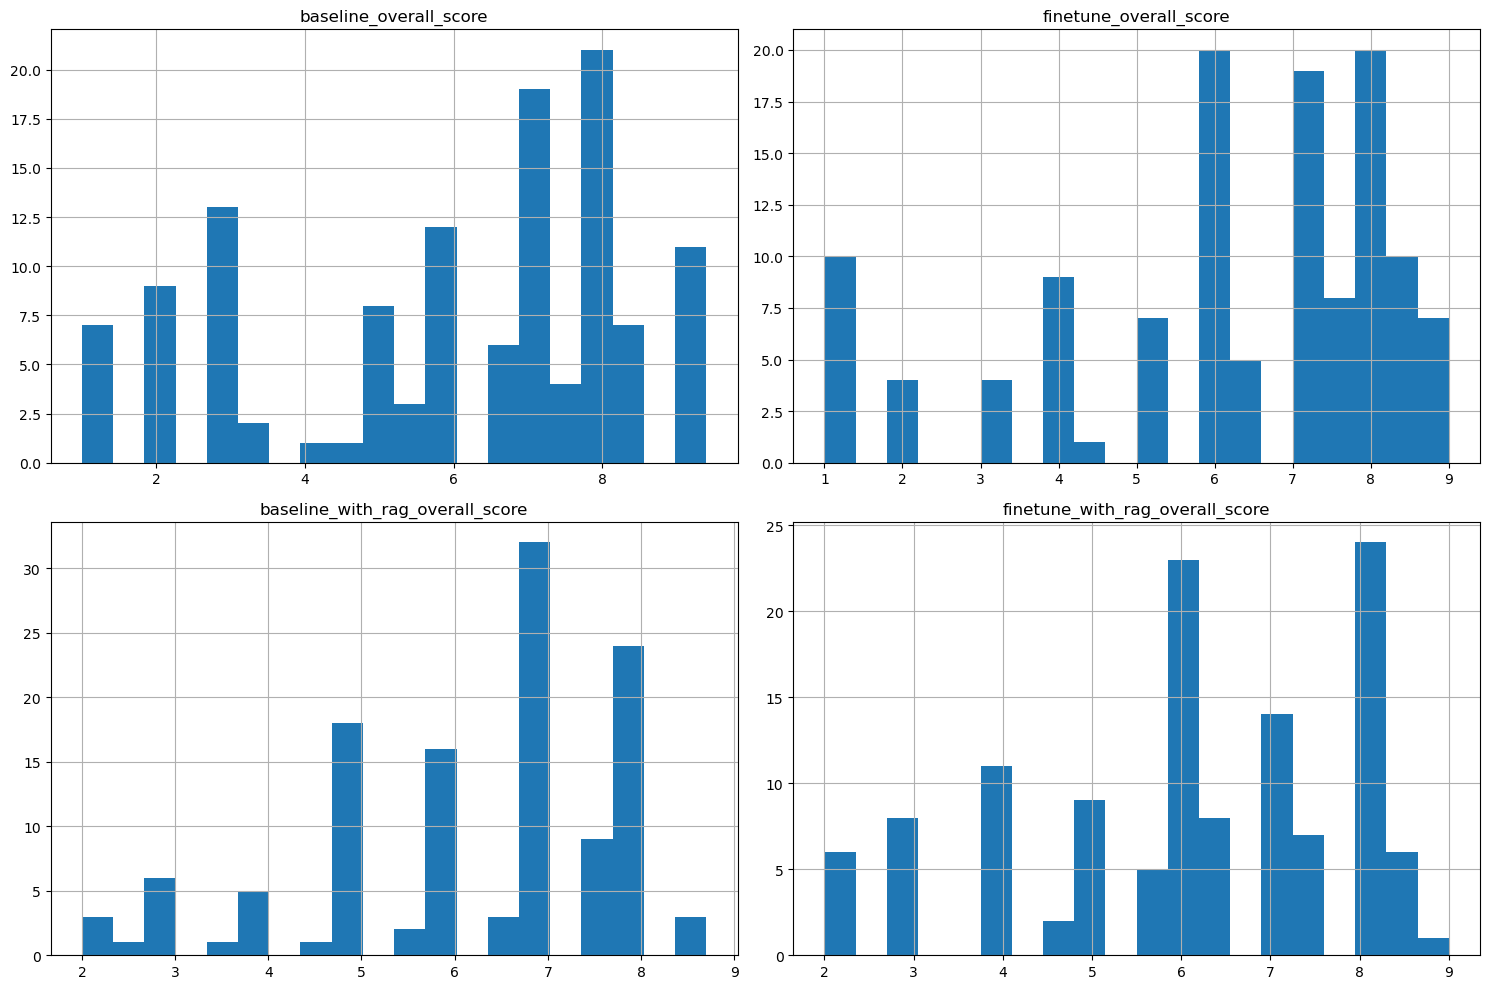

In [14]:
import matplotlib.pyplot as plt

# Plot the distribution of each column
new_df.hist(bins=20, figsize=(15, 10))
plt.tight_layout()
plt.show()